In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
import regex as re
import datetime
import time
import os
import json
import warnings
warnings.filterwarnings('ignore')
import sys
import sqlalchemy
import cx_Oracle
import pymssql
import pyodbc
import multiprocessing as mp

### 1. Load Data

In [3]:
#Open connection to DWH
#PREPARE CORRECT QUERY WITH ALL NEEDED COLUMNS


In [3]:
host=''
port=
sname=''
user=''
password=''
conn=cx_Oracle.connect('{}/{}@{}:{}/{}'.format(user,password,host,str(port),sname))
cur = conn.cursor()
query_select="""\
select * from AD_TOILOAN_TMP_ALL_02
where PRODUCT_CDE in
(
'60172--21060'
,'60127--21060'
,'60126--21050'
,'60036--21060'
,'60058--21050'
,'60052--21060'
)
"""

#offset 0 rows fetch next 4000001 rows only


In [4]:
cur.execute(query_select)

<cx_Oracle.Cursor on <cx_Oracle.Connection to DW_ANALYTICS@192.168.124.105:1594/DWDEV>>

In [5]:
# Create dataframe
col_names = []
for i in range (0,len(cur.description)):
    col_names.append(cur.description[i][0])
df_loan = pd.DataFrame(cur.fetchall(),columns = col_names)
cur.close()
conn.close()

In [7]:
len(df_loan)

1563702

In [8]:
df_loan.isnull().sum()

CUSTOMER_CDE     0
PRODUCT_CDE      0
LD_ID            0
AMT_INIT         0
AMT_CUR          0
INTEREST_RATE    0
RATE_FTP         0
KYHAN            0
LOAITRAGOP       0
MUCDICHVAY       0
LMV              0
LBV              0
ACCT_USE_DAYS    0
TOI              0
PROCESS_MONTH    0
PROCESS_YEAR     0
dtype: int64

In [9]:
df_loan.groupby('LOAITRAGOP')['LOAITRAGOP'].count().reset_index(name='count').sort_values(['count'],ascending=False)

,LOAITRAGOP,count
1,E,816171
0,B,580896
2,S,166635


In [9]:
# df_loan.fillna({'LOAITRAGOP':'B'}, inplace=True)

In [8]:
# df_loan.drop(df_loan[df_loan.LMV.isnull()==True].index,inplace=True)

In [10]:
df_b = df_loan[(df_loan.LOAITRAGOP =='E') | (df_loan.LOAITRAGOP =='B')]

In [11]:
df_b = df_b.reset_index(drop=True)

In [12]:
len(df_b)

1397067

In [13]:
df_b[df_b['AMT_CUR']<=1].count()

CUSTOMER_CDE     124038
PRODUCT_CDE      124038
LD_ID            124038
AMT_INIT         124038
AMT_CUR          124038
INTEREST_RATE    124038
RATE_FTP         124038
KYHAN            124038
LOAITRAGOP       124038
MUCDICHVAY       124038
LMV              124038
LBV              124038
ACCT_USE_DAYS    124038
TOI              124038
PROCESS_MONTH    124038
PROCESS_YEAR     124038
dtype: int64

In [14]:
df_b.drop(df_b[df_b['AMT_CUR']<=1].index,inplace=True)

In [15]:
df_b[df_b['TOI']<=1].count()

CUSTOMER_CDE     7704
PRODUCT_CDE      7704
LD_ID            7704
AMT_INIT         7704
AMT_CUR          7704
INTEREST_RATE    7704
RATE_FTP         7704
KYHAN            7704
LOAITRAGOP       7704
MUCDICHVAY       7704
LMV              7704
LBV              7704
ACCT_USE_DAYS    7704
TOI              7704
PROCESS_MONTH    7704
PROCESS_YEAR     7704
dtype: int64

In [16]:
df_b.drop(df_b[df_b['TOI']<=1].index,inplace=True)

In [17]:
df_b.groupby('LOAITRAGOP')['LOAITRAGOP'].count().reset_index(name='count').sort_values(['count'],ascending=False)

,LOAITRAGOP,count
1,E,735246
0,B,530079


In [18]:
df_b.columns

Index(['CUSTOMER_CDE', 'PRODUCT_CDE', 'LD_ID', 'AMT_INIT', 'AMT_CUR',
       'INTEREST_RATE', 'RATE_FTP', 'KYHAN', 'LOAITRAGOP', 'MUCDICHVAY', 'LMV',
       'LBV', 'ACCT_USE_DAYS', 'TOI', 'PROCESS_MONTH', 'PROCESS_YEAR'],
      dtype='object')

### 4. Exploration Data Analysis

In [19]:
numerical_columns=['AMT_INIT','AMT_CUR',
       'ACCT_USE_DAYS','INTEREST_RATE',
       'RATE_FTP','KYHAN','LMV','LBV','TOI']

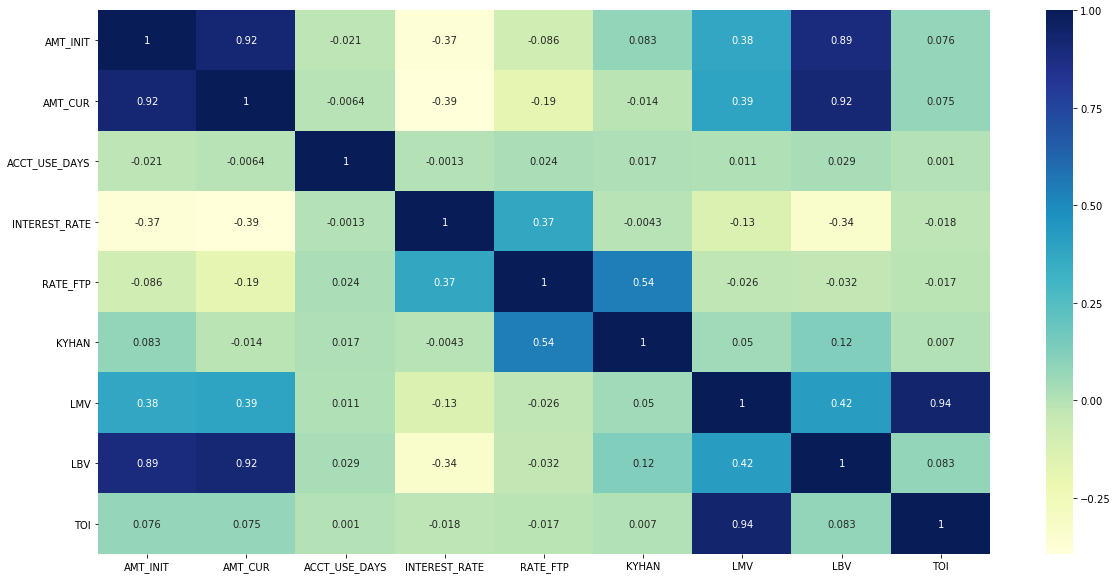

In [20]:
# Let's see the correlation between different variables.
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df_b[numerical_columns]. corr(), cmap="YlGnBu", annot = True)
plt.show()

In [206]:
# temp['LMV_LOG'] = pd.to_numeric(np.log(temp['LMV']), errors='coerce')

In [240]:
# df_b['AMT_INIT_LOG'] = pd.to_numeric(np.log(df_b['AMT_INIT']), errors='coerce')

In [21]:
df_b['AMT_CUR_LOG'] = pd.to_numeric(np.log(df_b['AMT_CUR']), errors='coerce')

In [22]:
df_b['TOI_LOG'] = pd.to_numeric(np.log(df_b['TOI']), errors='coerce')

### Build model

In [53]:
temp = df_b.copy()

In [54]:
len(temp)

1265325

In [55]:
col_model = ['PRODUCT_CDE','AMT_CUR_LOG', 'ACCT_USE_DAYS','RATE_FTP','INTEREST_RATE','KYHAN','TOI_LOG']

In [56]:
col_input = ['AMT_CUR_LOG', 'ACCT_USE_DAYS', 'RATE_FTP', 'INTEREST_RATE','KYHAN']

In [57]:
temp.drop_duplicates(subset=col_model, inplace=True)
temp = temp.reset_index(drop=True)

In [58]:
len(temp)
# 2067789
# 1994818

1015444

In [59]:
temp['TOI'].describe(include='all')

count    1.015444e+06
mean     5.309528e+05
std      5.246070e+06
min      6.074999e+00
25%      2.038759e+05
50%      3.760167e+05
75%      6.730443e+05
max      5.260677e+09
Name: TOI, dtype: float64

In [60]:
temp[temp['TOI']<1000]['TOI'].count()

125

In [61]:
temp = temp[(temp['TOI']>=1000) & (temp['TOI']<=20000000)]
temp = temp.reset_index(drop=True)

In [62]:
# temp[temp['AMT_INIT']<=1].count()

In [63]:
# temp.drop(temp[temp['AMT_INIT']<=1].index,inplace=True)

In [64]:
PRODUCT_CDE_df = pd.get_dummies(temp['PRODUCT_CDE'], prefix = 'PRODUCT_CDE')

In [65]:
# MUCDICHVAY_df = pd.get_dummies(temp['MUCDICHVAY'], prefix = 'MUCDICHVAY')

In [66]:
temp.drop(['PRODUCT_CDE'],axis=1, inplace = True)

In [67]:
temp2 = pd.concat([PRODUCT_CDE_df,temp[col_input]], axis = 1)

In [68]:
temp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015318 entries, 0 to 1015317
Data columns (total 11 columns):
PRODUCT_CDE_60036--21060    1015318 non-null uint8
PRODUCT_CDE_60052--21060    1015318 non-null uint8
PRODUCT_CDE_60058--21050    1015318 non-null uint8
PRODUCT_CDE_60126--21050    1015318 non-null uint8
PRODUCT_CDE_60127--21060    1015318 non-null uint8
PRODUCT_CDE_60172--21060    1015318 non-null uint8
AMT_CUR_LOG                 1015318 non-null float64
ACCT_USE_DAYS               1015318 non-null int64
RATE_FTP                    1015318 non-null float64
INTEREST_RATE               1015318 non-null float64
KYHAN                       1015318 non-null int64
dtypes: float64(3), int64(2), uint8(6)
memory usage: 44.5 MB


In [69]:
temp2.head()

,PRODUCT_CDE_60036--21060,PRODUCT_CDE_60052--21060,PRODUCT_CDE_60058--21050,PRODUCT_CDE_60126--21050,PRODUCT_CDE_60127--21060,PRODUCT_CDE_60172--21060,AMT_CUR_LOG,ACCT_USE_DAYS,RATE_FTP,INTEREST_RATE,KYHAN
0,0,1,0,0,0,0,20.212440,29,8.901944,10.0,84
1,1,0,0,0,0,0,18.420681,26,7.060000,8.8,12
2,0,0,0,1,0,0,18.420681,30,7.080000,11.0,12
3,0,0,0,1,0,0,18.826146,30,7.170000,10.9,12
4,0,0,1,0,0,0,19.434098,30,9.220000,10.8,60


In [70]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

In [71]:
robust=RobustScaler()
# s_rb=robust.fit_transform(temp[col_input])
s_rb=robust.fit_transform(temp2)

In [72]:
# df_mm = pd.DataFrame(s_rb, columns=col_input)
df_mm = pd.DataFrame(s_rb, columns=temp2.columns)

In [73]:
df_mm.columns

Index(['PRODUCT_CDE_60036--21060', 'PRODUCT_CDE_60052--21060',
       'PRODUCT_CDE_60058--21050', 'PRODUCT_CDE_60126--21050',
       'PRODUCT_CDE_60127--21060', 'PRODUCT_CDE_60172--21060', 'AMT_CUR_LOG',
       'ACCT_USE_DAYS', 'RATE_FTP', 'INTEREST_RATE', 'KYHAN'],
      dtype='object')

In [74]:
df_mm.head()

,PRODUCT_CDE_60036--21060,PRODUCT_CDE_60052--21060,PRODUCT_CDE_60058--21050,PRODUCT_CDE_60126--21050,PRODUCT_CDE_60127--21060,PRODUCT_CDE_60172--21060,AMT_CUR_LOG,ACCT_USE_DAYS,RATE_FTP,INTEREST_RATE,KYHAN
0,0.0,1.0,0.0,0.0,0.0,0.0,0.835121,-2.0,0.265916,-1.192308,1.000000
1,1.0,0.0,0.0,0.0,0.0,0.0,-0.359633,-5.0,-0.729730,-2.115385,-1.000000
2,0.0,0.0,0.0,1.0,0.0,0.0,-0.359633,-1.0,-0.718919,-0.423077,-1.000000
3,0.0,0.0,0.0,1.0,0.0,0.0,-0.089267,-1.0,-0.670270,-0.500000,-1.000000
4,0.0,0.0,1.0,0.0,0.0,0.0,0.316119,-1.0,0.437838,-0.576923,0.333333


In [133]:
df_mm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015318 entries, 0 to 1015317
Data columns (total 11 columns):
PRODUCT_CDE_60036--21060    1015318 non-null float64
PRODUCT_CDE_60052--21060    1015318 non-null float64
PRODUCT_CDE_60058--21050    1015318 non-null float64
PRODUCT_CDE_60126--21050    1015318 non-null float64
PRODUCT_CDE_60127--21060    1015318 non-null float64
PRODUCT_CDE_60172--21060    1015318 non-null float64
AMT_CUR_LOG                 1015318 non-null float64
ACCT_USE_DAYS               1015318 non-null float64
RATE_FTP                    1015318 non-null float64
INTEREST_RATE               1015318 non-null float64
KYHAN                       1015318 non-null float64
dtypes: float64(11)
memory usage: 85.2 MB


In [132]:
df_mm.groupby('PRODUCT_CDE_60052--21060')['PRODUCT_CDE_60052--21060'].count().reset_index(name='count').sort_values(['count'],ascending=False)

,PRODUCT_CDE_60052--21060,count
0,0.0,816412
1,1.0,198906


In [75]:
len(df_mm)

1015318

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_mm, temp['TOI_LOG'], test_size=0.2, random_state=42)

In [77]:
from sklearn.metrics import mean_squared_error, r2_score

In [620]:
# from sklearn.ensemble import RandomForestRegressor

# rfr = RandomForestRegressor()
# rfr.fit(X_train, y_train)
# y_pred_rf = rfr.predict(X_test)

In [78]:
import xgboost as xgb

rfr = xgb.XGBRegressor(learning_rate=0.05,max_depth=4,n_estimators=5000)
rfr.fit(X_train, y_train)
y_pred_rf = rfr.predict(X_test)

In [79]:
# print(f'RMSE        = {mean_squared_error(y_test, y_pred_rf)**0.5:.4f}')
print(f'MSE        = {mean_squared_error(y_test, y_pred_rf):.4f}')
print(f'R-squared   = {r2_score(y_test, y_pred_rf):.4f}')

MSE        = 0.0098
R-squared   = 0.9895


In [80]:
y_test = y_test.reset_index(drop=True)
y_test_ser = pd.Series(y_test)
y_pred_rf_ser = pd.Series(y_pred_rf)
data_result2  = pd.concat([y_pred_rf_ser, y_test_ser], axis=1, keys=['TOI_LOAN_PREDICT', 'TOI_LOAN_ACTUAL'])

In [81]:
data_result2 = np.exp(data_result2)

In [82]:
data_result2.head(20)

,TOI_LOAN_PREDICT,TOI_LOAN_ACTUAL
0,1.329471e+05,1.360685e+05
1,5.179148e+05,5.146849e+05
2,6.112430e+05,7.044881e+05
3,9.147544e+05,9.192150e+05
4,3.371568e+04,3.427945e+04
5,6.375235e+04,6.076389e+04
6,1.176912e+05,1.185000e+05
7,1.353744e+05,1.464110e+05
8,6.623082e+05,6.524333e+05
9,4.291290e+05,4.719406e+05


In [83]:
data_result2['TOI_STD']=abs(data_result2['TOI_LOAN_ACTUAL']-data_result2['TOI_LOAN_PREDICT'])

In [86]:
data_result2.sort_values(by='TOI_LOAN_ACTUAL',ascending=False).head(40)

,TOI_LOAN_PREDICT,TOI_LOAN_ACTUAL,TOI_STD
100036,1.427867e+07,1.442733e+07,1.486609e+05
34782,1.385315e+07,1.426849e+07,4.153441e+05
184166,1.401826e+07,1.394484e+07,7.342515e+04
138299,1.406261e+07,1.249399e+07,1.568619e+06
32364,1.138065e+07,1.167583e+07,2.951809e+05
61393,1.071800e+07,1.149467e+07,7.766664e+05
178518,9.200840e+06,9.653146e+06,4.523062e+05
72930,9.080561e+06,9.633633e+06,5.530726e+05
32215,8.426948e+06,8.944207e+06,5.172592e+05
18,8.690701e+06,8.464361e+06,2.263396e+05


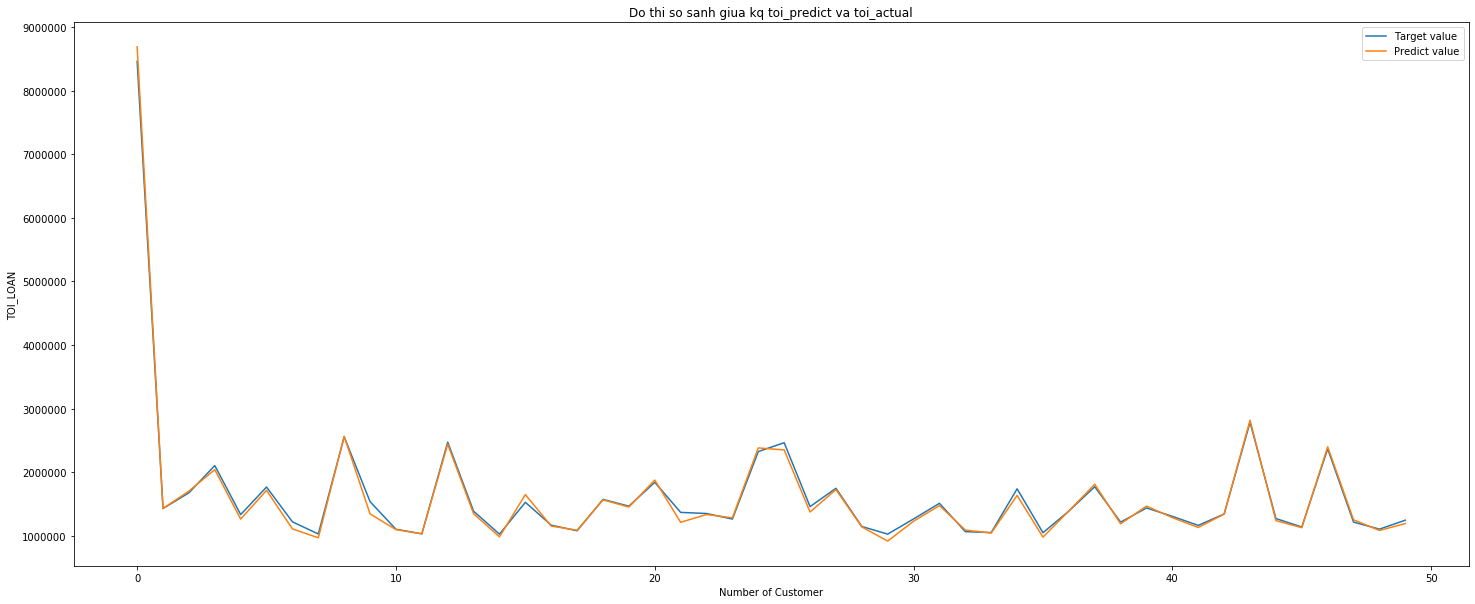

In [87]:
#Generate plot 
fig, ax = plt.subplots(figsize=(25,10))
neighbors = np.arange(0,50)
plt.title('Do thi so sanh giua kq toi_predict va toi_actual') 
plt.plot(neighbors, data_result2[(data_result2['TOI_LOAN_ACTUAL']>1000000)]['TOI_LOAN_ACTUAL'][0:50], label='Target value') 
plt.plot(neighbors, data_result2[(data_result2['TOI_LOAN_ACTUAL']>1000000)]['TOI_LOAN_PREDICT'][0:50], label='Predict value') 
plt.legend() 
plt.xlabel('Number of Customer') 
plt.ylabel('TOI_LOAN') 
plt.show()

In [88]:
print(rfr.feature_importances_) #use inbuilt class feature_importances of tree based regressor
#plot graph of feature importances for better visualization
feat_importances = pd.Series(rfr.feature_importances_, index=col_model)
feat_importances.nlargest(3).plot(kind='barh')
plt.show()

[0.00247652 0.00098028 0.00131967 0.00230495 0.00219269 0.00244265
 0.40927815 0.2996181  0.075226   0.2027345  0.00142644]


ValueError: Length of passed values is 11, index implies 7

In [42]:
# udfs ----

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [43]:
base_imp = imp_df(input_col, rfr.feature_importances_)
base_imp

,feature,feature_importance
0,AMT_CUR_LOG,0.999686
1,ACCT_USE_DAYS,0.000229
2,RATE_FTP_END,0.000045
3,INTEREST_RATE_END,0.000041


In [89]:
from sklearn.externals import joblib
# Save the model as a pickle in a file  
joblib.dump(rfr, 'xgb_toiloan_group01.pkl')

D:\Soft\Setup_UAT_DA\Winpython64-3.7.4.1\WPy64-3741\python-3.7.4.amd64\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['xgb_toiloan_group01.pkl']

In [90]:
joblib.dump(robust, 'xgb_toiloan_group01_scaler.pkl')

['xgb_toiloan_group01_scaler.pkl']

### TEST DATA 2020

In [91]:
path = r'C:\Users\phongtn25381\Downloads\PHONGTN_TOI_PHASE2\DP\inference\inference_toiloan_group01' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_test = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_test)

df_test = pd.concat(li, axis=0, ignore_index=True)

In [92]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237302 entries, 0 to 237301
Data columns (total 16 columns):
CUSTOMER_CDE     237302 non-null int64
PRODUCT_CDE      237302 non-null object
LD_ID            237302 non-null object
AMT_INIT         237302 non-null int64
AMT_CUR          237302 non-null int64
INTEREST_RATE    237302 non-null float64
RATE_FTP         237302 non-null float64
KYHAN            237302 non-null int64
LOAITRAGOP       237302 non-null object
MUCDICHVAY       237302 non-null int64
LMV              237302 non-null float64
LBV              237302 non-null float64
ACCT_USE_DAYS    237302 non-null int64
TOI              237302 non-null float64
PROCESS_MONTH    237302 non-null int64
PROCESS_YEAR     237302 non-null int64
dtypes: float64(5), int64(8), object(3)
memory usage: 29.0+ MB


In [96]:
df_test.groupby('LOAITRAGOP')['LOAITRAGOP'].count().reset_index(name='count').sort_values(['count'],ascending=False)

,LOAITRAGOP,count
1,E,156419
2,S,65955
0,B,14928


In [147]:
df_b_test = df_test[(df_test.LOAITRAGOP =='E') | (df_test.LOAITRAGOP =='B')]

In [148]:
len(df_b_test)

171347

In [149]:
df_b_test = df_b_test.reset_index(drop=True)

In [150]:
df_b_test[df_b_test['AMT_CUR']<=1].count()

CUSTOMER_CDE     8291
PRODUCT_CDE      8291
LD_ID            8291
AMT_INIT         8291
AMT_CUR          8291
INTEREST_RATE    8291
RATE_FTP         8291
KYHAN            8291
LOAITRAGOP       8291
MUCDICHVAY       8291
LMV              8291
LBV              8291
ACCT_USE_DAYS    8291
TOI              8291
PROCESS_MONTH    8291
PROCESS_YEAR     8291
dtype: int64

In [151]:
df_b_test.drop(df_b_test[df_b_test['AMT_CUR']<=1].index,inplace=True)

In [154]:
df_b_test[df_b_test['TOI']<=1].count()

CUSTOMER_CDE     107
PRODUCT_CDE      107
LD_ID            107
AMT_INIT         107
AMT_CUR          107
INTEREST_RATE    107
RATE_FTP         107
KYHAN            107
LOAITRAGOP       107
MUCDICHVAY       107
LMV              107
LBV              107
ACCT_USE_DAYS    107
TOI              107
PROCESS_MONTH    107
PROCESS_YEAR     107
dtype: int64

In [155]:
df_b_test.drop(df_b_test[df_b_test['TOI']<=1].index,inplace=True)

In [156]:
df_b_test.groupby('PRODUCT_CDE')['PRODUCT_CDE'].count().reset_index(name='count').sort_values(['count'],ascending=False)

,PRODUCT_CDE,count
6,60172--21060,56564
4,60126--21050,29751
5,60127--21060,28322
1,60052--21060,27549
2,60058--21050,20735
3,60058--21060,15
0,60052--21050,13


In [ ]:
"""
'60172--21060'
,'60127--21060'
,'60126--21050'
,--'60036--21060'
,'60058--21050'
,'60052--21060'
"""

In [157]:
list_A = ['60172--21060'
,'60127--21060'
,'60126--21050'
,'60058--21050'
,'60052--21060']

In [158]:
df_b_test = df_b_test[df_b_test['PRODUCT_CDE'].isin(list_A)]

In [160]:
df_b_test = df_b_test.reset_index(drop=True)

In [161]:
df_b_test.groupby('PRODUCT_CDE')['PRODUCT_CDE'].count().reset_index(name='count').sort_values(['count'],ascending=False)

,PRODUCT_CDE,count
4,60172--21060,56564
2,60126--21050,29751
3,60127--21060,28322
0,60052--21060,27549
1,60058--21050,20735


In [162]:
df_b_test = df_b_test[(df_b_test['TOI']>=1000) & (df_b_test['TOI']<=20000000)]
df_b_test = df_b_test.reset_index(drop=True)

In [163]:
df_b_test['AMT_CUR_LOG'] = pd.to_numeric(np.log(df_b_test['AMT_CUR']), errors='coerce')

In [164]:
PRODUCT_CDE_df_test = pd.get_dummies(df_b_test['PRODUCT_CDE'], prefix = 'PRODUCT_CDE')

In [166]:
PRODUCT_CDE_df_test.head()

,PRODUCT_CDE_60052--21060,PRODUCT_CDE_60058--21050,PRODUCT_CDE_60126--21050,PRODUCT_CDE_60127--21060,PRODUCT_CDE_60172--21060
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [171]:
# PRODUCT_CDE_df_test.drop('PRODUCT_CDE_60036--21060', axis=1, inplace=True) 

In [172]:
idx = 0
PRODUCT_CDE_df_test.insert(loc=idx,column='PRODUCT_CDE_60036--21060',value=0)

In [176]:
PRODUCT_CDE_df_test['PRODUCT_CDE_60052--21060'] = PRODUCT_CDE_df_test['PRODUCT_CDE_60052--21060'].astype('int64')
PRODUCT_CDE_df_test['PRODUCT_CDE_60058--21050'] = PRODUCT_CDE_df_test['PRODUCT_CDE_60058--21050'].astype('int64')
PRODUCT_CDE_df_test['PRODUCT_CDE_60126--21050'] = PRODUCT_CDE_df_test['PRODUCT_CDE_60126--21050'].astype('int64')
PRODUCT_CDE_df_test['PRODUCT_CDE_60127--21060'] = PRODUCT_CDE_df_test['PRODUCT_CDE_60127--21060'].astype('int64')
PRODUCT_CDE_df_test['PRODUCT_CDE_60172--21060'] = PRODUCT_CDE_df_test['PRODUCT_CDE_60172--21060'].astype('int64')
PRODUCT_CDE_df_test['PRODUCT_CDE_60036--21060'] = PRODUCT_CDE_df_test['PRODUCT_CDE_60036--21060'].astype('int64')

In [177]:
PRODUCT_CDE_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162914 entries, 0 to 162913
Data columns (total 6 columns):
PRODUCT_CDE_60036--21060    162914 non-null int64
PRODUCT_CDE_60052--21060    162914 non-null int64
PRODUCT_CDE_60058--21050    162914 non-null int64
PRODUCT_CDE_60126--21050    162914 non-null int64
PRODUCT_CDE_60127--21060    162914 non-null int64
PRODUCT_CDE_60172--21060    162914 non-null int64
dtypes: int64(6)
memory usage: 7.5 MB


In [179]:
PRODUCT_CDE_df_test.head()

,PRODUCT_CDE_60036--21060,PRODUCT_CDE_60052--21060,PRODUCT_CDE_60058--21050,PRODUCT_CDE_60126--21050,PRODUCT_CDE_60127--21060,PRODUCT_CDE_60172--21060
0,0,0,0,0,0,1
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


In [181]:
PRODUCT_CDE_df_test.groupby('PRODUCT_CDE_60052--21060')['PRODUCT_CDE_60052--21060'].count().reset_index(name='count').sort_values(['count'],ascending=False)

,PRODUCT_CDE_60052--21060,count
0,0,135368
1,1,27546


In [183]:
df_b_test.columns

Index(['CUSTOMER_CDE', 'LD_ID', 'AMT_INIT', 'AMT_CUR', 'INTEREST_RATE',
       'RATE_FTP', 'KYHAN', 'LOAITRAGOP', 'MUCDICHVAY', 'LMV', 'LBV',
       'ACCT_USE_DAYS', 'TOI', 'PROCESS_MONTH', 'PROCESS_YEAR', 'AMT_CUR_LOG'],
      dtype='object')

In [182]:
df_b_test.drop(['PRODUCT_CDE'],axis=1, inplace = True)

KeyError: "['PRODUCT_CDE'] not found in axis"

In [184]:
col_test = ['AMT_CUR_LOG', 'ACCT_USE_DAYS', 'RATE_FTP', 'INTEREST_RATE','KYHAN']

In [185]:
df_b_test_02 = pd.concat([PRODUCT_CDE_df_test,df_b_test[col_test]], axis = 1)

In [119]:
# df_b_test_02['PRODUCT_CDE_60036--21060'] = 0

In [186]:
df_b_test_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162914 entries, 0 to 162913
Data columns (total 11 columns):
PRODUCT_CDE_60036--21060    162914 non-null int64
PRODUCT_CDE_60052--21060    162914 non-null int64
PRODUCT_CDE_60058--21050    162914 non-null int64
PRODUCT_CDE_60126--21050    162914 non-null int64
PRODUCT_CDE_60127--21060    162914 non-null int64
PRODUCT_CDE_60172--21060    162914 non-null int64
AMT_CUR_LOG                 162914 non-null float64
ACCT_USE_DAYS               162914 non-null int64
RATE_FTP                    162914 non-null float64
INTEREST_RATE               162914 non-null float64
KYHAN                       162914 non-null int64
dtypes: float64(3), int64(8)
memory usage: 13.7 MB


In [187]:
df_b_test_02.head()

,PRODUCT_CDE_60036--21060,PRODUCT_CDE_60052--21060,PRODUCT_CDE_60058--21050,PRODUCT_CDE_60126--21050,PRODUCT_CDE_60127--21060,PRODUCT_CDE_60172--21060,AMT_CUR_LOG,ACCT_USE_DAYS,RATE_FTP,INTEREST_RATE,KYHAN
0,0,0,0,0,0,1,17.253361,31,9.35,20.4,36
1,0,0,0,0,0,1,16.965851,31,9.35,20.4,36
2,0,0,0,0,0,1,17.119903,31,9.35,20.4,36
3,0,0,0,0,0,1,17.909888,31,9.28,18.6,35
4,0,0,0,0,0,1,17.946251,29,9.28,18.6,35


In [188]:
s_rb2=robust.transform(df_b_test_02)

In [189]:
df_mm_test = pd.DataFrame(s_rb2, columns=df_b_test_02.columns)

In [190]:
df_mm_test.head()

,PRODUCT_CDE_60036--21060,PRODUCT_CDE_60052--21060,PRODUCT_CDE_60058--21050,PRODUCT_CDE_60126--21050,PRODUCT_CDE_60127--21060,PRODUCT_CDE_60172--21060,AMT_CUR_LOG,ACCT_USE_DAYS,RATE_FTP,INTEREST_RATE,KYHAN
0,0.0,0.0,0.0,0.0,0.0,1.0,-1.138007,0.0,0.508108,6.807692,-0.333333
1,0.0,0.0,0.0,0.0,0.0,1.0,-1.329720,0.0,0.508108,6.807692,-0.333333
2,0.0,0.0,0.0,0.0,0.0,1.0,-1.226997,0.0,0.508108,6.807692,-0.333333
3,0.0,0.0,0.0,0.0,0.0,1.0,-0.700231,0.0,0.470270,5.423077,-0.361111
4,0.0,0.0,0.0,0.0,0.0,1.0,-0.675984,-2.0,0.470270,5.423077,-0.361111


In [191]:
df_mm_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162914 entries, 0 to 162913
Data columns (total 11 columns):
PRODUCT_CDE_60036--21060    162914 non-null float64
PRODUCT_CDE_60052--21060    162914 non-null float64
PRODUCT_CDE_60058--21050    162914 non-null float64
PRODUCT_CDE_60126--21050    162914 non-null float64
PRODUCT_CDE_60127--21060    162914 non-null float64
PRODUCT_CDE_60172--21060    162914 non-null float64
AMT_CUR_LOG                 162914 non-null float64
ACCT_USE_DAYS               162914 non-null float64
RATE_FTP                    162914 non-null float64
INTEREST_RATE               162914 non-null float64
KYHAN                       162914 non-null float64
dtypes: float64(11)
memory usage: 13.7 MB


In [192]:
y_pred_rf2 = rfr.predict(df_mm_test)

In [193]:
y_pred_rf2 = np.exp(y_pred_rf2)

In [195]:
y_test2 = df_b_test['TOI']

In [205]:
print(f'Tong sai lech            = {mean_squared_error(y_test2, y_pred_rf2)**0.5:.4f}')
print(f'Do phu hop cua mo hinh   = {r2_score(y_test2, y_pred_rf2)*100:.4f} %')

Tong sai lech            = 49976.2625
Do phu hop cua mo hinh   = 99.0813 %


In [202]:
y_test2 = y_test2.reset_index(drop=True)
y_test2_ser = pd.Series(y_test2)
y_pred_rf2_ser = pd.Series(y_pred_rf2)
data_result3  = pd.concat([y_pred_rf2_ser, y_test2_ser], axis=1, keys=['TOI_LOAN_PREDICT', 'TOI_LOAN_ACTUAL'])

In [203]:
data_result3['TOI_STD']=abs(data_result3['TOI_LOAN_ACTUAL']-data_result3['TOI_LOAN_PREDICT'])

In [204]:
data_result3.sort_values(by='TOI_LOAN_ACTUAL',ascending=False).head(20)

,TOI_LOAN_PREDICT,TOI_LOAN_ACTUAL,TOI_STD
44224,12753018.0,1.412329e+07,1.370270e+06
92473,11120410.0,1.189093e+07,7.705207e+05
92113,11104429.0,1.161282e+07,5.083885e+05
92245,11104429.0,1.131031e+07,2.058795e+05
92472,10457743.0,1.110537e+07,6.476280e+05
92246,10194624.0,1.102241e+07,8.277889e+05
59264,11042250.0,1.094937e+07,9.288014e+04
59186,10486686.0,1.024296e+07,2.437271e+05
59263,4284778.0,1.009370e+07,5.808921e+06
59718,11042250.0,9.864438e+06,1.177812e+06
